# **Riesgo crediticio**
*Mateo Arenas Montoya*  
*Ingeniero Fisico*  
*Especialista en Analitica*  
*mateo0431@gmail.com*

Este notebook presenta la solución a un problema de clasificación de riesgo crediticio, desarrollado como parte de la prueba técnica para el cargo de *Analista de Riesgos de Negocio y Riesgos Emergentes*. Se realiza el análisis y preprocesamiento de los datos, seguido de la evaluación de distintos modelos de clasificación para diferenciar clientes Good y Bad, con el fin de analizar su desempeño desde una perspectiva de riesgo.

___________________________________________
### Importación de librerías 

Esta celda importa las dependencias necesarias para el análisis y modelado:

- pandas (pd): carga y manipulación de datos (DataFrame).
- numpy (np): operaciones numéricas y matrices.
- seaborn (sns) y matplotlib.pyplot (plt): visualización y gráficos.
- train_test_split: particionar datos en entrenamiento y prueba.
- LogisticRegression: modelo de regresión logística para clasificación.
- accuracy_score, confusion_matrix, classification_report: métricas de evaluación de modelos.
- BernoulliNB: clasificador Naive Bayes (discreto/binario).
- SVC: Support Vector Machine para clasificación.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from IPython.display import display
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score, recall_score

___________
### Carga de Datos
Se realiza la carga del conjunto de datos.

Dado que el archivo original no contiene encabezados de columna, se asignan nombres genéricos a las variables independientes *(x1, x2, …, x20)* y se define la variable objetivo como *y*, lo cual facilita el manejo y la interpretación posterior de los datos.

Adicionalmente, se imprime la dimensión del dataset y un resumen de su estructura, con el fin de obtener una primera noción sobre el número de observaciones, tipos de datos y valores faltantes.

In [2]:

df = pd.read_csv('data/german.csv', header = None)
df.columns = [f'x{i}' for i in range(1, df.shape[1])] + ['y']
print(df.shape)
print(df.info())
df.head()


(1000, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   x1      1000 non-null   object
 1   x2      1000 non-null   int64 
 2   x3      1000 non-null   object
 3   x4      1000 non-null   object
 4   x5      1000 non-null   int64 
 5   x6      1000 non-null   object
 6   x7      1000 non-null   object
 7   x8      1000 non-null   int64 
 8   x9      1000 non-null   object
 9   x10     1000 non-null   object
 10  x11     1000 non-null   int64 
 11  x12     1000 non-null   object
 12  x13     1000 non-null   int64 
 13  x14     1000 non-null   object
 14  x15     1000 non-null   object
 15  x16     1000 non-null   int64 
 16  x17     1000 non-null   object
 17  x18     1000 non-null   int64 
 18  x19     1000 non-null   object
 19  x20     1000 non-null   object
 20  y       1000 non-null   object
dtypes: int64(7), object(14)
memory usage: 164.2+ KB
No

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x12,x13,x14,x15,x16,x17,x18,x19,x20,y
0,<0,6,critical/other existing credit,radio/tv,1169,no known savings,>=7,4,male single,none,...,real estate,67,none,own,2,skilled,1,yes,yes,good
1,0<=X<200,48,existing paid,radio/tv,5951,<100,1<=X<4,2,female div/dep/mar,none,...,real estate,22,none,own,1,skilled,1,none,yes,bad
2,no checking,12,critical/other existing credit,education,2096,<100,4<=X<7,2,male single,none,...,real estate,49,none,own,1,unskilled resident,2,none,yes,good
3,<0,42,existing paid,furniture/equipment,7882,<100,4<=X<7,2,male single,guarantor,...,life insurance,45,none,for free,1,skilled,2,none,yes,good
4,<0,24,delayed previously,new car,4870,<100,1<=X<4,3,male single,none,...,no known property,53,none,for free,2,skilled,2,none,yes,bad


___________
### Identificación de Variables Categóricas
Se analizan las variables de tipo object con el objetivo de identificar el número de categorías presentes en cada una.

Se ve la naturaleza categórica de las variables, así como la diversidad de valores que toman, información clave para decidir la estrategia de preprocesamiento.

In [3]:
for col in df.select_dtypes(include='object').columns:
    print(f"--- Columna: {col} ---")
    print(df[col].value_counts(dropna=False))


--- Columna: x1 ---
x1
no checking    394
<0             274
0<=X<200       269
>=200           63
Name: count, dtype: int64
--- Columna: x3 ---
x3
existing paid                     530
critical/other existing credit    293
delayed previously                 88
all paid                           49
no credits/all paid                40
Name: count, dtype: int64
--- Columna: x4 ---
x4
radio/tv               280
new car                234
furniture/equipment    181
used car               103
business                97
education               50
repairs                 22
domestic appliance      12
other                   12
retraining               9
Name: count, dtype: int64
--- Columna: x6 ---
x6
<100                603
no known savings    183
100<=X<500          103
500<=X<1000          63
>=1000               48
Name: count, dtype: int64
--- Columna: x7 ---
x7
1<=X<4        339
>=7           253
4<=X<7        174
<1            172
unemployed     62
Name: count, dtype: int64
--- Colum

___________
### Separación de Variables y Codificación Categórica
Se realiza la separación de las variables independientes y la variable objetivo, donde *X* corresponde al conjunto de características explicativas y *y* representa la variable de interés.

Luego, a las variables categóricas se aplica una *codificación One-Hot Encoding*. Esta técnica permite transformar las variables categóricas en variables binarias, evitando la imposición de un orden artificial entre categorías y facilitando su uso en modelos de clasificación lineales y no lineales. Adicionalmente, se elimina una de las categorías de referencia con el fin de evitar problemas de colinealidad.

Adicionalmente, la variable objetivo es transformada a una representación numérica, donde Good se codifica como 1 y Bad como 0, con el fin de facilitar el entrenamiento y la evaluación de los modelos.

Finalmente, se inspecciona la dimensión resultante del conjunto de datos y la distribución de la variable objetivo, lo cual permite verificar el impacto de la codificación y evidenciar el desbalance entre clases presente, el cual corresponde a 300 observaciones de la clase Bad y 700 de la clase Good.

In [4]:
# Variables explicativas
X = df.drop(columns='y')

# Variable objetivo
y = df['y']


In [5]:
X.select_dtypes(include='object').columns
X_encoded = pd.get_dummies(X, drop_first=True)
print(X_encoded.shape)
X_encoded.head()

(1000, 48)


,x2,x5,x8,x11,x13,x16,x18,x1_<0,x1_>=200,x1_no checking,...,x12_real estate,x14_none,x14_stores,x15_own,x15_rent,x17_skilled,x17_unemp/unskilled non res,x17_unskilled resident,x19_yes,x20_yes
0,6,1169,4,4,67,2,1,True,False,False,...,True,True,False,True,False,True,False,False,True,True
1,48,5951,2,2,22,1,1,False,False,False,...,True,True,False,True,False,True,False,False,False,True
2,12,2096,2,3,49,1,2,False,False,True,...,True,True,False,True,False,False,False,True,False,True
3,42,7882,2,4,45,1,2,True,False,False,...,False,True,False,False,False,True,False,False,False,True
4,24,4870,3,4,53,2,2,True,False,False,...,False,True,False,False,False,True,False,False,False,True


In [6]:
y_encoded = y.map({'good': 1, 'bad': 0})
print(y_encoded.value_counts())

y
1    700
0    300
Name: count, dtype: int64


________
### Correlación 
Se calcula la matriz de correlación de las variables, con el objetivo de identificar posibles relaciones lineales fuertes entre ellas que pudieran justificar una reducción de dimensionalidad.

Al analizar, la mayor correlación observada es aproximadamente 0.74, lo cual no se considera suficientemente alto como para justificar la eliminación de variables o la aplicación de técnicas de reducción de dimensionalidad. En consecuencia, se decide conservar todas las variables para el entrenamiento de los modelos.

In [7]:
corr_matrix = X_encoded.corr()

high_corr = (
    corr_matrix.abs()
    .where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    .stack()
)

high_corr = high_corr[high_corr > 0.6].sort_values(ascending=False)

print(high_corr.head(10))


x15_own                            x15_rent                  0.735968
x10_guarantor                      x10_none                  0.731408
x3_critical/other existing credit  x3_existing paid          0.683617
x17_skilled                        x17_unskilled resident    0.652438
x2                                 x5                        0.624984
dtype: float64


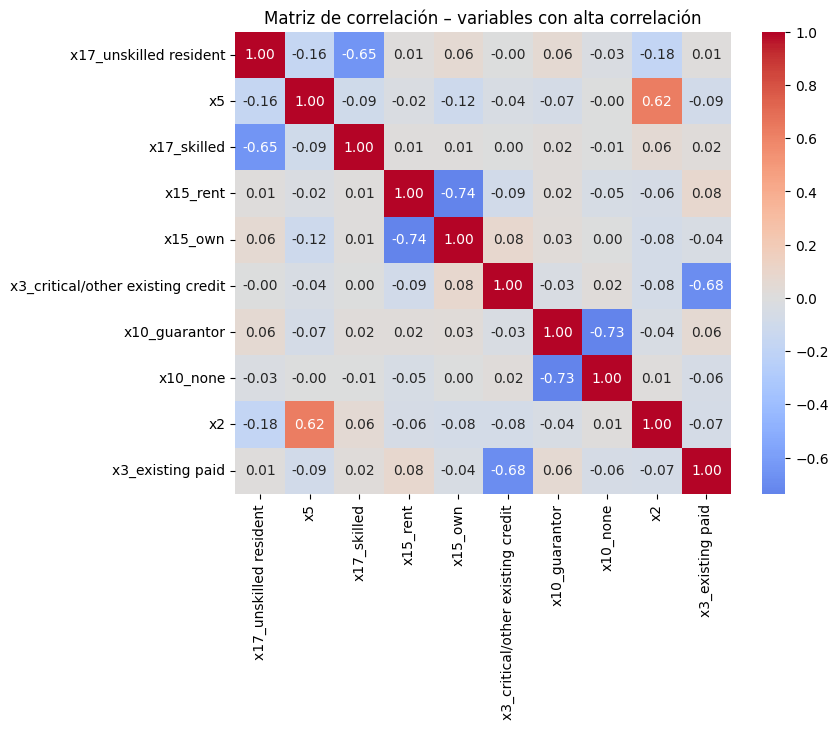

In [8]:
vars_high_corr = list(
    set([var for pair in high_corr.index for var in pair])
)

corr_subset = corr_matrix.loc[vars_high_corr, vars_high_corr]

plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_subset,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0
)
plt.title("Matriz de correlación – variables con alta correlación")
plt.show()

_______
### División de Datos 
Se realiza la división del conjunto de datos en entrenamiento y prueba, utilizando una proporción del 70 % para entrenamiento y 30 % para prueba.

Se conservar la proporción original de las clases Good y Bad en ambos subconjuntos. Para garantiza que los modelos se entrenen y evalúen bajo una distribución representativa de la realidad, evitando escenarios artificiales que podrían sesgar la interpretación de los resultados.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded,
    y_encoded,
    test_size=0.3,
    random_state=42,
    stratify=y_encoded
)

print("Distribución en entrenamiento:")
print(y_train.value_counts(normalize=True))

print("\nDistribución en prueba:")
print(y_test.value_counts(normalize=True))


Distribución en entrenamiento:
y
1    0.7
0    0.3
Name: proportion, dtype: float64

Distribución en prueba:
y
1    0.7
0    0.3
Name: proportion, dtype: float64


__________
### Regresion Logistica

Este modelo permite estimar la probabilidad de pertenencia a una clase (Good o Bad) a partir de una combinación lineal de las variables explicativas, aplicando una función logística.

Se entrenan dos configuraciones del modelo con el objetivo de evaluar el impacto del manejo del desbalance de clases:

- Modelo base, entrenado sin ponderación de clases, preservando la distribución original de los datos.
- Modelo ajustado, incorporando ponderación de clases (class_weight='balanced') para penalizar de forma diferencial los errores asociados a la clase minoritaria (Bad).

Ambos modelos utilizan regularización L2, la cual ayuda a controlar el sobreajuste y es una elección estándar en contextos de clasificación binaria

En esta primera configuración, el modelo se entrena sin corrección explícita del desbalance

In [10]:
log_model = LogisticRegression(
    penalty='l2',
    max_iter=1000,
    random_state=42,
    tol=0.001,
    solver='liblinear'
)

In [11]:
log_model.fit(X_train, y_train)

y_pred_log = log_model.predict(X_test)

/home/mateo/Documents/Pruebas/Sura/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


En esta segunda configuración, se incorpora la opción *class_weight='balanced'*, la cual ajusta automáticamente los pesos de las clases de forma inversamente proporcional a su frecuencia. Este enfoque busca incrementar la capacidad del modelo para detectar clientes Bad.

In [12]:
log_model_2 = LogisticRegression(
    penalty='l2',
    max_iter=1000,
    random_state=42,
    tol=0.001,
    class_weight='balanced',
    solver='lbfgs'
)

In [13]:
log_model_2.fit(X_train, y_train)

y_pred_log_2 = log_model_2.predict(X_test)

/home/mateo/Documents/Pruebas/Sura/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/home/mateo/Documents/Pruebas/Sura/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regress

____________
### Naive Bayes
Se emplea la variante *Bernoulli Naive Bayes*, la cual resulta adecuada para conjuntos de datos con variables binarias, como las obtenidas tras la aplicación de *One-Hot Encoding*.

In [14]:
nb_model = BernoulliNB()

In [15]:
nb_model.fit(X_train, y_train)

y_pred_nb = nb_model.predict(X_test)

### Support Vector Machine (SVM)

se emplea como un enfoque discriminativo que busca encontrar la frontera de decisión óptima que maximiza el margen entre las clases Good y Bad.

Se utiliza una configuración simple con kernel lineal, lo cual permite evaluar el desempeño del modelo sin introducir complejidad adicional ni requerir procesos extensivos de ajuste de hiperparámetros.

In [16]:
svm_model = SVC(
    kernel='linear',
    C=1.0,
    probability=True,
    random_state=42,
)

In [17]:
svm_model.fit(X_train, y_train)

y_pred_svm = svm_model.predict(X_test)


## Analisis

In [18]:
models = {
    'Logistic': y_pred_log,
    'Logistic_balanced': y_pred_log_2,
    'NaiveBayes': y_pred_nb,
    'SVM': y_pred_svm
}

#### Matrices de confusión

Se evalúa el desempeño de los modelos mediante la matriz de confusión, tanto en valores absolutos como normalizados, lo cual permite analizar no solo el volumen de errores, sino también su proporción relativa entre clases.

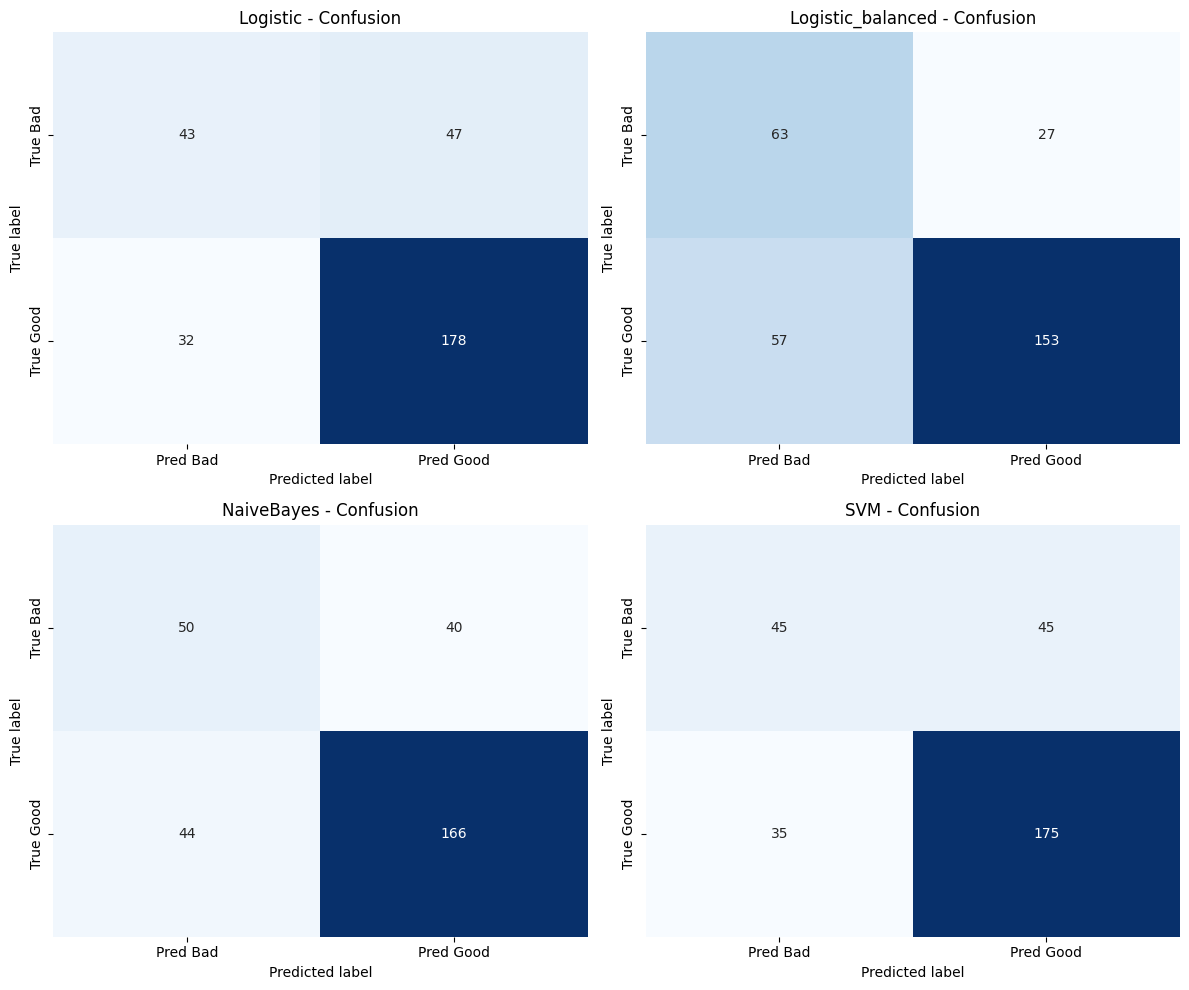

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()
for ax, (name, y_pred) in zip(axes, models.items()):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Pred Bad', 'Pred Good'],
                yticklabels=['True Bad', 'True Good'],
                ax=ax)
    ax.set_title(f'{name} - Confusion')
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
plt.tight_layout()
plt.show()

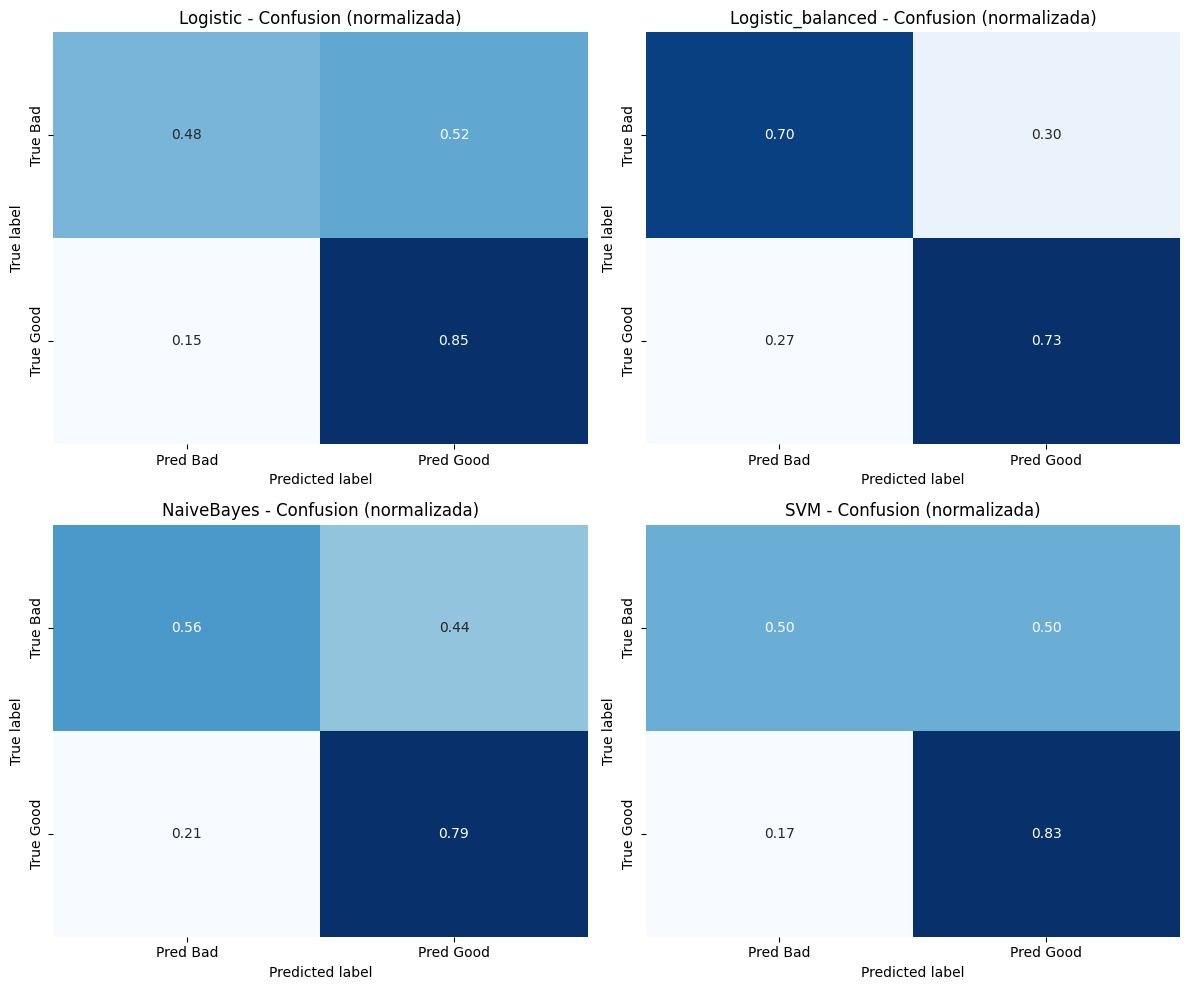

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()
for ax, (name, y_pred) in zip(axes, models.items()):
    cm = confusion_matrix(y_test, y_pred).astype(float)
    cm_norm = cm / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', cbar=False,
                xticklabels=['Pred Bad', 'Pred Good'],
                yticklabels=['True Bad', 'True Good'],
                ax=ax)
    ax.set_title(f'{name} - Confusion (normalizada)')
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
plt.tight_layout()
plt.show()

Al analizar las matrices de confusión de los modelos evaluados, se observa que el primer modelo de Regresión Logística presenta el mejor desempeño en la predicción de la clase Good, logrando identificar el 85% de los clientes de bajo riesgo. Sin embargo, este modelo presenta una limitación importante desde la perspectiva de riesgo, ya que el recall de la clase Bad es de 48%, lo cual implica un número considerable de clientes de alto riesgo clasificados incorrectamente como Good, representando un riesgo significativo.

Dado este contexto, la prioridad del análisis se centra en reducir los falsos positivos de la clase Bad, sin afectar de forma excesiva la correcta identificación de los clientes Good. 

Por su parte, el modelo Naive Bayes muestra una mayor sensibilidad hacia la clase Bad con un recall de 56%. Este comportamiento Viene acompañado de un incremento en los falsos negativos, es decir, clientes Good clasificados como Bad, lo cual puede impactar negativamente en la aprobación de clientes solventes.

El modelo SVM con kernel lineal ofrece una frontera de decisión más estricta en comparación con modelos probabilísticos como Naive Bayes. Su desempeño resulta comparable al de la regresión logística.

Finalmente se observa que el modelo de regresión logística con ponderación de clases incrementa la capacidad de detección de clientes Bad, con un racall del 70% , aunque a costa de una reducción en el recall para la clase Good.


#### Metricas

=== Logistic ===


,precision,recall,f1-score
Bad,0.57,0.48,0.52
Good,0.79,0.85,0.82
accuracy,0.74,0.74,0.74
macro avg,0.68,0.66,0.67
weighted avg,0.73,0.74,0.73


=== Logistic_balanced ===


,precision,recall,f1-score
Bad,0.52,0.70,0.60
Good,0.85,0.73,0.78
accuracy,0.72,0.72,0.72
macro avg,0.69,0.71,0.69
weighted avg,0.75,0.72,0.73


=== NaiveBayes ===


,precision,recall,f1-score
Bad,0.53,0.56,0.54
Good,0.81,0.79,0.80
accuracy,0.72,0.72,0.72
macro avg,0.67,0.67,0.67
weighted avg,0.72,0.72,0.72


=== SVM ===


,precision,recall,f1-score
Bad,0.56,0.50,0.53
Good,0.80,0.83,0.81
accuracy,0.73,0.73,0.73
macro avg,0.68,0.67,0.67
weighted avg,0.73,0.73,0.73


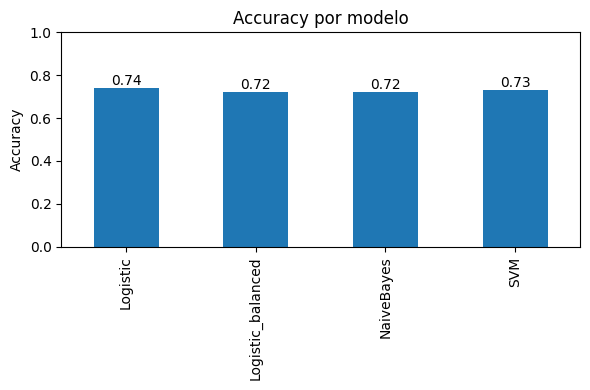

In [21]:
reports = {}
accuracies = {}
for name, y_pred in models.items():
    rep_dict = classification_report(y_test, y_pred, target_names=['Bad', 'Good'], output_dict=True)
    df_rep = pd.DataFrame(rep_dict).T
    df_rep = df_rep.round(2)
    df_display = df_rep.drop(columns=['support'], errors='ignore')
    print(f'=== {name} ===')

    display(df_display)

    accuracies[name] = accuracy_score(y_test, y_pred)


accuracy_df = pd.Series(accuracies, name='accuracy').to_frame()
accuracy_df['accuracy'] = accuracy_df['accuracy'].round(2)

ax = accuracy_df.plot(kind='bar', legend=False, figsize=(6, 4), color=['C0'])
ax.set_ylim(0, 1)
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy por modelo')
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom')
plt.tight_layout()
plt.show()

Al analizar las métricas de desempeño de los cuatro modelos evaluados, se observa que el accuracy es muy similar entre ellos. Sin embargo, esta métrica por sí sola no es suficiente para evaluar modelos en un contexto de riesgo crediticio, ya que no distingue entre los diferentes tipos de error.

En particular, el principal interés del análisis es evitar falsos positivos en la clase Bad, es decir, minimizar los casos en los que se otorga crédito a clientes de alto riesgo. Por esta razón, se consideran métricas adicionales que permiten una evaluación más detallada:

- **Precision:** indica qué proporción de las observaciones clasificadas como una clase determinada son realmente correctas. En el caso de la clase Bad, una baja precisión implica rechazar clientes Good innecesariamente.

- **Recall:** mide la capacidad del modelo para identificar correctamente todas las observaciones reales de una clase. Para la clase Bad refleja la capacidad del modelo para detectar clientes de alto riesgo.

- **F1-score:** corresponde al promedio armónico entre precision y recall, y permite evaluar el equilibrio entre ambas métricas, especialmente útil en conjuntos de datos desbalanceados.

A partir del análisis de estas métricas, se observa que el segundo modelo de Regresión Logística (con ponderación de clases) presenta el mejor desempeño desde la perspectiva de riesgo, alcanzando un recall de aproximadamente 70% para la clase Bad, superior al de los demás modelos evaluados. Aunque el recall para la clase Good no es el más alto, se mantiene en un nivel razonable (alrededor del 73%), lo cual representa un compromiso adecuado entre detección de riesgo y aprobación de clientes.

### Adicional

In [24]:
models = {
    "Logistic_1": log_model,
    "Logistic_2": log_model_2,
    "Naive_Bayes": nb_model,
    "SVM": svm_model
}

import numpy as np
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    recall_score,
    precision_score,
    classification_report
)

thresholds_analysis = np.linspace(0.1, 0.9, 81)

for name, model in models.items():
    print("=" * 60)
    print(f"MODELO: {name}")
    print("=" * 60)

    y_prob = model.predict_proba(X_test)[:, 1]

    auc = roc_auc_score(y_test, y_prob)
    print(f"AUC: {auc:.3f}")

    fpr, tpr, thresholds_roc = roc_curve(y_test, y_prob)
    ks = tpr - fpr
    ks_max = ks.max()
    threshold_ks = thresholds_roc[np.argmax(ks)]

    print(f"KS máximo: {ks_max:.3f}")
    print(f"Threshold KS: {threshold_ks:.3f}")

    for t in thresholds_analysis:
        y_pred = (y_prob >= t).astype(int)
        recall = recall_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)

    y_pred_final = (y_prob >= threshold_ks).astype(int)

    print("\nClassification report (threshold KS):")
    print(classification_report(
        y_test,
        y_pred_final,
        target_names=["Good", "Bad"]
    ))


MODELO: Logistic_1
AUC: 0.780
KS máximo: 0.475
Threshold KS: 0.752

Classification report (threshold KS):
              precision    recall  f1-score   support

        Good       0.52      0.79      0.63        90
         Bad       0.88      0.69      0.77       210

    accuracy                           0.72       300
   macro avg       0.70      0.74      0.70       300
weighted avg       0.77      0.72      0.73       300

MODELO: Logistic_2
AUC: 0.774
KS máximo: 0.437
Threshold KS: 0.480

Classification report (threshold KS):
              precision    recall  f1-score   support

        Good       0.54      0.69      0.60        90
         Bad       0.85      0.75      0.79       210

    accuracy                           0.73       300
   macro avg       0.69      0.72      0.70       300
weighted avg       0.76      0.73      0.74       300

MODELO: Naive_Bayes
AUC: 0.753
KS máximo: 0.444
Threshold KS: 0.779

Classification report (threshold KS):
              precision    

En este problema el objetivo principal es identificar correctamente a los clientes con mayor riesgo de incumplimiento (BAD), ya que una mala clasificación implica pérdidas económicas directas para la entidad. Por esta razón, la evaluación de los modelos no se basa únicamente en la métrica de accuracy, sino en métricas estándar de riesgo crediticio como el AUC, el estadístico KS y el Recall de la clase BAD, además de la correcta selección del threshold de decisión.

Los modelos de clasificación no producen directamente una decisión Good/Bad, sino una probabilidad de incumplimiento (probabilidad de ser BAD). El **threshold** define el punto de corte a partir del cual un cliente es clasificado como BAD. Un threshold bajo permite detectar un mayor número de clientes riesgosos (mayor recall de BAD), pero incrementa el rechazo de clientes buenos, mientras que un threshold alto reduce los rechazos, pero aumenta el riesgo de aprobar clientes con alta probabilidad de incumplimiento. Por esta razón, el threshold no debe fijarse arbitrariamente (por ejemplo en 0.5), sino que debe elegirse de forma óptima de acuerdo con los objetivos de negocio y riesgo. En este análisis se utiliza el threshold que maximiza el estadístico KS, ya que corresponde al punto de mayor separación entre las distribuciones de clientes GOOD y BAD.

El **AUC** (Area Under the ROC Curve) mide la capacidad del modelo para ordenar correctamente a los clientes según su nivel de riesgo. En términos prácticos, el AUC representa la probabilidad de que el modelo asigne un mayor score de riesgo a un cliente BAD que a uno GOOD, independientemente del threshold utilizado. Un AUC cercano a 0.5 indica un modelo aleatorio, valores entre 0.7 y 0.8 indican un modelo con buen desempeño y valores superiores a 0.8 reflejan una muy buena capacidad predictiva.

El estadístico **KS** (Kolmogorov–Smirnov) mide la máxima separación entre las distribuciones acumuladas de los scores de GOOD y BAD. Permite evaluar qué tan bien el modelo discrimina entre clientes buenos y malos y, adicionalmente, identificar el threshold óptimo de clasificación. Valores de KS superiores a 0.4 suelen considerarse buenos y valores superiores a 0.5 excelentes.

Los resultados obtenidos muestran que el modelo Logistic_1 presenta el mejor desempeño global, con el mayor AUC (0.780) y el mayor KS (0.475), lo que indica la mejor capacidad de discriminación entre clientes GOOD y BAD. El modelo Logistic_2 alcanza el mayor Recall de BAD (75%), lo cual es positivo desde el punto de vista del control de riesgo, aunque presenta una ligera reducción en la capacidad de separación global. Los modelos Naive Bayes y SVM presentan desempeños aceptables, pero no superan a los modelos logísticos en términos de AUC y KS.

Considerando las métricas estándar de riesgo, la capacidad de discriminación y la estabilidad del modelo, el modelo recomendado para este problema de riesgo crediticio es Logistic_1. Este modelo ofrece el mejor balance entre separación de clases, desempeño predictivo y facilidad de interpretación, lo cual es fundamental en entornos financieros y regulatorios. No obstante, si el criterio de negocio prioriza maximizar la detección de clientes BAD, el modelo Logistic_2 podría considerarse como alternativa ajustando el threshold de decisión según la política de riesgo.